Shapes - X_train: (183112, 48) X_test: (78477, 48)
Shapes - y_train: (183112,) y_test: (78477,)
Shapes after SMOTE - X_train_res: (455199, 48) y_train_res: (455199,)
Best parameters: {'max_depth': None, 'n_estimators': 200}
Epoch 1/10
11380/11380 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.6310 - loss: 0.8220 - val_accuracy: 0.1705 - val_loss: 1.5357
Epoch 2/10
11380/11380 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.7051 - loss: 0.6956 - val_accuracy: 0.2055 - val_loss: 1.5958
Epoch 3/10
11380/11380 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.7291 - loss: 0.6485 - val_accuracy: 0.2207 - val_loss: 1.5457
Epoch 4/10
11380/11380 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.7403 - loss: 0.6246 - val_accuracy: 0.3153 - val_loss: 1.3564
Epoch 5/10
11380/11380 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.7472 - loss: 0.6092 - val_accuracy: 0.2272 - val_loss: 1.6257
Epoch 6/10
11380/11380 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.7531 - loss: 0.5956 - val_accuracy: 0.26


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.94      0.62      0.75     65029
         1.0       0.04      0.30      0.07      1974
         2.0       0.33      0.58      0.42     11474

    accuracy                           0.61     78477
   macro avg       0.44      0.50      0.41     78477
weighted avg       0.83      0.61      0.68     78477

ROC-AUC Score for Logistic Regression: 0.7404


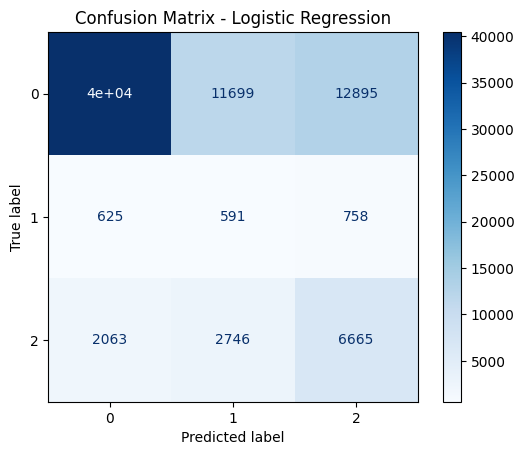


Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89     65029
         1.0       0.03      0.01      0.01      1974
         2.0       0.38      0.27      0.31     11474

    accuracy                           0.81     78477
   macro avg       0.42      0.40      0.40     78477
weighted avg       0.77      0.81      0.78     78477

ROC-AUC Score for Random Forest: 0.7055


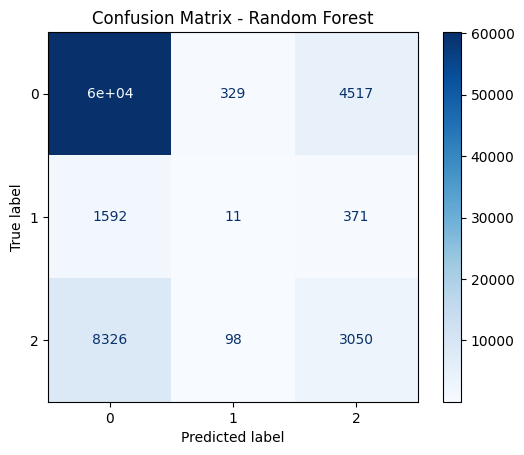


Classification Report for Tuned Random Forest:
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89     65029
         1.0       0.03      0.01      0.01      1974
         2.0       0.38      0.27      0.31     11474

    accuracy                           0.81     78477
   macro avg       0.42      0.40      0.40     78477
weighted avg       0.77      0.81      0.78     78477

ROC-AUC Score for Tuned Random Forest: 0.7055


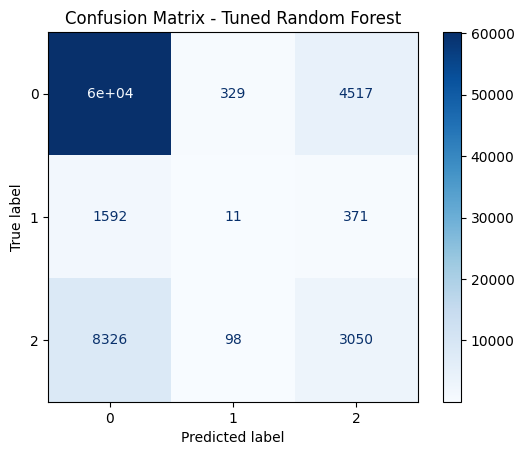

2453/2453 ━━━━━━━━━━━━━━━━━━━━ 2s 714us/step

Classification Report for Neural Network:
              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87     65029
         1.0       0.03      0.12      0.05      1974
         2.0       0.43      0.30      0.35     11474

    accuracy                           0.76     78477
   macro avg       0.45      0.43      0.42     78477
weighted avg       0.79      0.76      0.77     78477

ROC-AUC Score for Neural Network: 0.7506


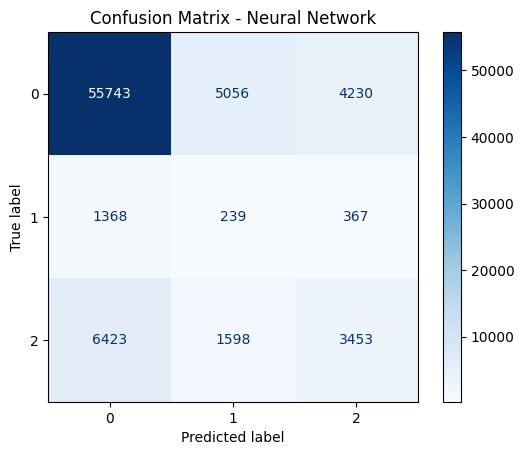

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV, train_test_split
from joblib import load, dump
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')  # Ignore deprecation warnings for now

# Define paths
processed_data_path = '../data/processed/'
models_path = '../models/'

# Create models directory if it doesn't exist
os.makedirs(models_path, exist_ok=True)

# Load preprocessed data
X_train = np.load(os.path.join(processed_data_path, 'X_train.npy'))
X_test = np.load(os.path.join(processed_data_path, 'X_test.npy'))
y_train = np.load(os.path.join(processed_data_path, 'y_train.npy'))
y_test = np.load(os.path.join(processed_data_path, 'y_test.npy'))

# Check shapes
print("Shapes - X_train:", X_train.shape, "X_test:", X_test.shape)
print("Shapes - y_train:", y_train.shape, "y_test:", y_test.shape)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
X_train_res = X_train_res.toarray() if hasattr(X_train_res, 'toarray') else X_train_res  # Ensure dense
y_train_res = y_train_res.astype(np.float32)  # Ensure picklable type
print("Shapes after SMOTE - X_train_res:", X_train_res.shape, "y_train_res:", y_train_res.shape)

# Hyperparameter Tuning for Random Forest with subset
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
X_train_sub, _, y_train_sub, _ = train_test_split(X_train_res, y_train_res, train_size=0.1, random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1_weighted', n_jobs=1)
grid_search.fit(X_train_sub, y_train_sub)
print("Best parameters:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train_res, y_train_res)  # Retrain on full data
dump(best_rf_model, os.path.join(models_path, 'random_forest_tuned.pkl'))

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_res, y_train_res)
dump(log_reg, os.path.join(models_path, 'logistic_regression_smote.pkl'))

# Train Tuned Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, class_weight='balanced')
rf_model.fit(X_train_res, y_train_res)
dump(rf_model, os.path.join(models_path, 'random_forest_smote_tuned.pkl'))

# Prepare data for Neural Network (one-hot encode y for multi-class)
y_train_cat = to_categorical(y_train_res, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Build and train Neural Network
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_res.shape[1],)),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train_res, y_train_cat, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
nn_model.save(os.path.join(models_path, 'neural_net.h5'))

# Evaluate all models
models = {'Logistic Regression': log_reg, 'Random Forest': rf_model, 'Tuned Random Forest': best_rf_model}
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score for {name}: {roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr'):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Evaluate Neural Network
y_pred_nn = nn_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)
print("\nClassification Report for Neural Network:")
print(classification_report(y_test, y_pred_nn_classes))
print(f"ROC-AUC Score for Neural Network: {roc_auc_score(y_test, y_pred_nn, multi_class='ovr', average='weighted'):.4f}")

cm_nn = confusion_matrix(y_test, y_pred_nn_classes)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn)
disp_nn.plot(cmap='Blues')
plt.title('Confusion Matrix - Neural Network')
plt.show()

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Num GPUs Available: 0
No GPU detected. Training will use CPU.
Shapes - X_train: (183112, 48) X_test: (78477, 48)
Shapes - y_train: (183112,) y_test: (78477,)
Shapes after SMOTE - X_train_res: (183505, 48) y_train_res: (183505,)
Epoch 1/30
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8283 - loss: 0.4727 - val_accuracy: 0.8266 - val_loss: 0.4809
Epoch 2/30
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8307 - loss: 0.4550 - val_accuracy: 0.8267 - val_loss: 0.4791
Epoch 3/30
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8318 - loss: 0.4517 - val_accuracy: 0.8261 - val_loss: 0.4776
Epoch 4/30
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8320 - loss: 0.4493 - val_accuracy: 0.8267 - val_loss: 0.4770
Epoch 5/30
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8325 - loss: 0.4484 - val_accuracy: 0.8277 - val_loss: 0.4790
Epoch 6/30
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8326 - loss: 0.4465 - val_accuracy: 0.8256 - val_loss

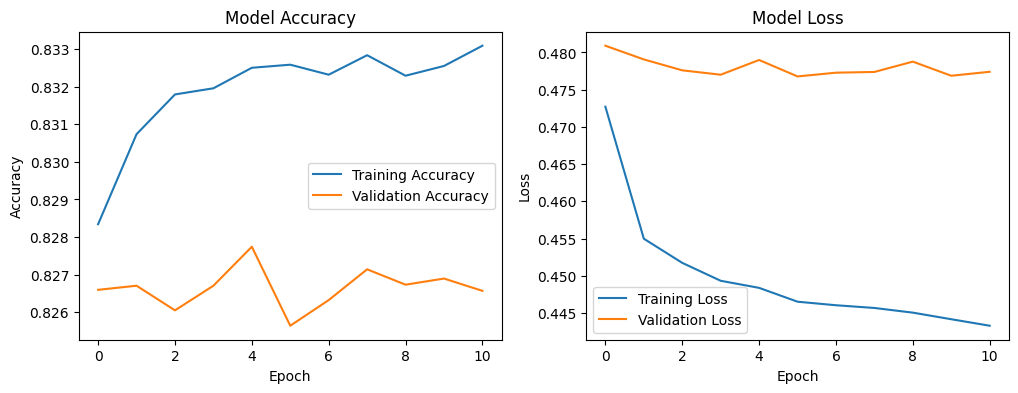


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.94      0.63      0.76     65029
         1.0       0.04      0.29      0.07      1974
         2.0       0.33      0.60      0.42     11474

    accuracy                           0.62     78477
   macro avg       0.44      0.51      0.42     78477
weighted avg       0.83      0.62      0.69     78477

ROC-AUC Score for Logistic Regression: 0.7458


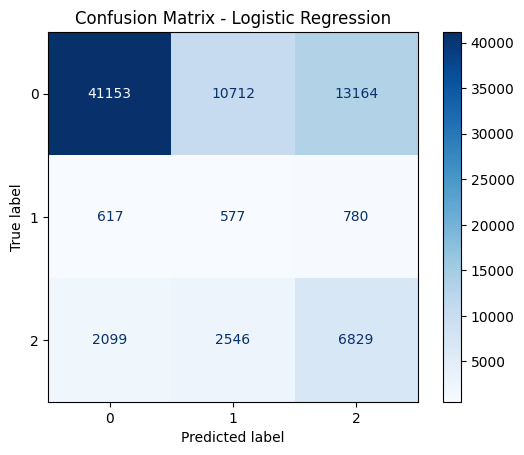


Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89     65029
         1.0       0.02      0.01      0.01      1974
         2.0       0.37      0.15      0.21     11474

    accuracy                           0.81     78477
   macro avg       0.41      0.37      0.37     78477
weighted avg       0.75      0.81      0.77     78477

ROC-AUC Score for Random Forest: 0.7046


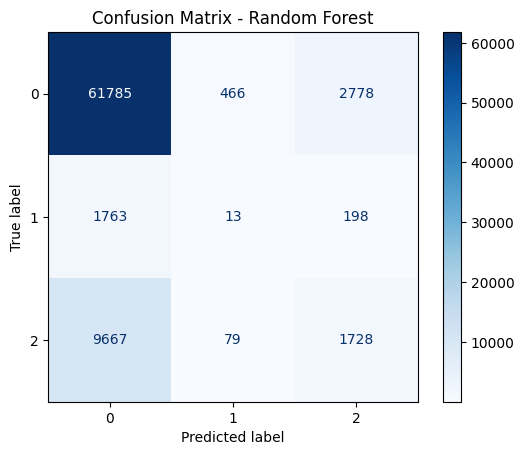

2453/2453 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Classification Report for Neural Network:
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91     65029
         1.0       0.00      0.00      0.00      1974
         2.0       0.62      0.05      0.09     11474

    accuracy                           0.83     78477
   macro avg       0.49      0.35      0.33     78477
weighted avg       0.78      0.83      0.76     78477

ROC-AUC Score for Neural Network: 0.7935


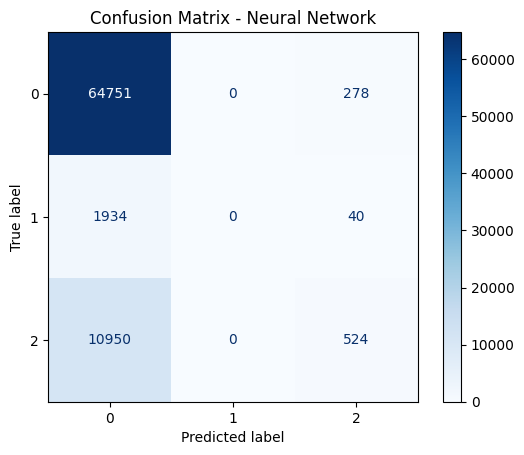

In [6]:

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

# Verify GPU availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("GPU:", tf.config.list_physical_devices('GPU')[0].name)
else:
    print("No GPU detected. Training will use CPU.")

# Define paths
processed_data_path = '../data/processed/'
models_path = '../models/'

# Create models directory if it doesn't exist
os.makedirs(models_path, exist_ok=True)

# Load preprocessed data
X_train = np.load(os.path.join(processed_data_path, 'X_train.npy'))
X_test = np.load(os.path.join(processed_data_path, 'X_test.npy'))
y_train = np.load(os.path.join(processed_data_path, 'y_train.npy'))
y_test = np.load(os.path.join(processed_data_path, 'y_test.npy'))

# Check shapes
print("Shapes - X_train:", X_train.shape, "X_test:", X_test.shape)
print("Shapes - y_train:", y_train.shape, "y_test:", y_test.shape)

# Apply SMOTE with adjusted sampling strategy
smote = SMOTE(sampling_strategy={1: 5000, 2: 26772}, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
X_train_res = X_train_res.toarray() if hasattr(X_train_res, 'toarray') else X_train_res
y_train_res = y_train_res.astype(np.float32)
print("Shapes after SMOTE - X_train_res:", X_train_res.shape, "y_train_res:", y_train_res.shape)

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_res, y_train_res)
dump(log_reg, os.path.join(models_path, 'logistic_regression_smote.pkl'))

# Train Random Forest with tuned parameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, class_weight='balanced')
rf_model.fit(X_train_res, y_train_res)
dump(rf_model, os.path.join(models_path, 'random_forest_smote_tuned.pkl'))

# Prepare data for Neural Network
y_train_cat = to_categorical(y_train_res, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Build and train Neural Network with CPU/GPU support
with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
    nn_model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_res.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = nn_model.fit(X_train_res, y_train_cat, epochs=30, batch_size=128, validation_split=0.2,
                          verbose=1, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])
    nn_model.save(os.path.join(models_path, 'neural_net_tuned.h5'))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate all models
models = {'Logistic Regression': log_reg, 'Random Forest': rf_model}
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score for {name}: {roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr'):.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Evaluate Neural Network
y_pred_nn = nn_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)
print("\nClassification Report for Neural Network:")
print(classification_report(y_test, y_pred_nn_classes))
print(f"ROC-AUC Score for Neural Network: {roc_auc_score(y_test, y_pred_nn, multi_class='ovr', average='weighted'):.4f}")

cm_nn = confusion_matrix(y_test, y_pred_nn_classes)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn)
disp_nn.plot(cmap='Blues')
plt.title('Confusion Matrix - Neural Network')
plt.show()

Num GPUs Available: 0
No GPU detected. Training will use CPU.
Shapes - X_train: (183112, 48) X_test: (78477, 48)
Shapes - y_train: (183112,) y_test: (78477,)
Shapes after SMOTE - X_train_res: (183505, 48) y_train_res: (183505,)
Epoch 1/30
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6830 - loss: 1.6328 - val_accuracy: 0.6557 - val_loss: 0.7371
Epoch 2/30
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6923 - loss: 1.5850 - val_accuracy: 0.6815 - val_loss: 0.6940
Epoch 3/30
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6955 - loss: 1.5735 - val_accuracy: 0.6911 - val_loss: 0.6860
Epoch 4/30
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6950 - loss: 1.5678 - val_accuracy: 0.6974 - val_loss: 0.6827
Epoch 5/30
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6977 - loss: 1.5612 - val_accuracy: 0.6826 - val_loss: 0.6974
Epoch 6/30
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6972 - loss: 1.5604 - val_accuracy: 0.6696 - val_loss:

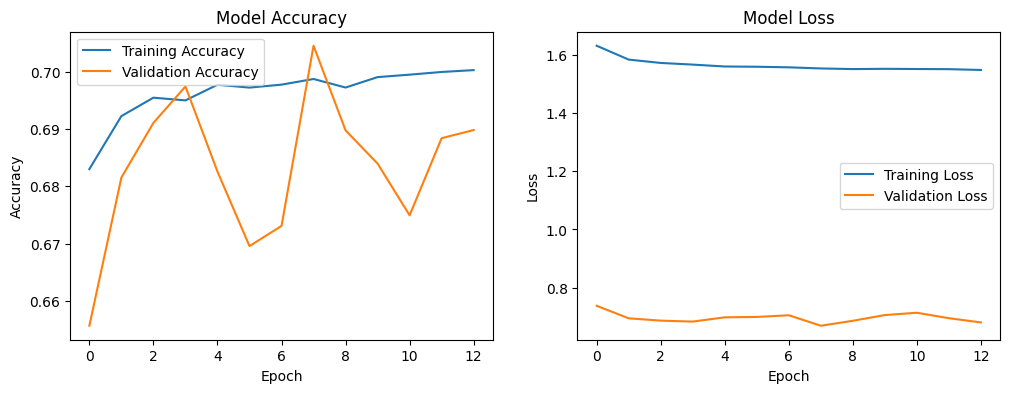


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.94      0.63      0.76     65029
         1.0       0.04      0.29      0.07      1974
         2.0       0.33      0.60      0.42     11474

    accuracy                           0.62     78477
   macro avg       0.44      0.51      0.42     78477
weighted avg       0.83      0.62      0.69     78477

ROC-AUC Score for Logistic Regression: 0.7458


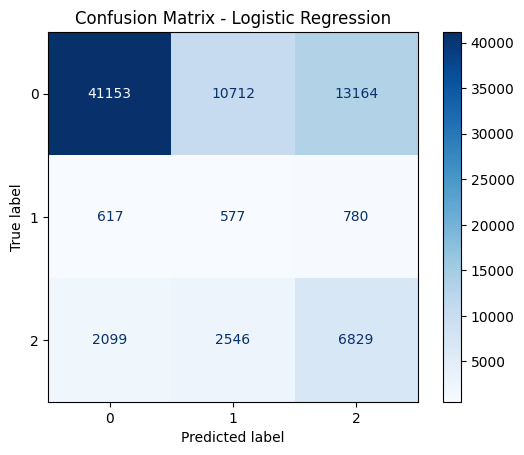


Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89     65029
         1.0       0.02      0.01      0.01      1974
         2.0       0.37      0.15      0.21     11474

    accuracy                           0.81     78477
   macro avg       0.41      0.37      0.37     78477
weighted avg       0.75      0.81      0.77     78477

ROC-AUC Score for Random Forest: 0.7046


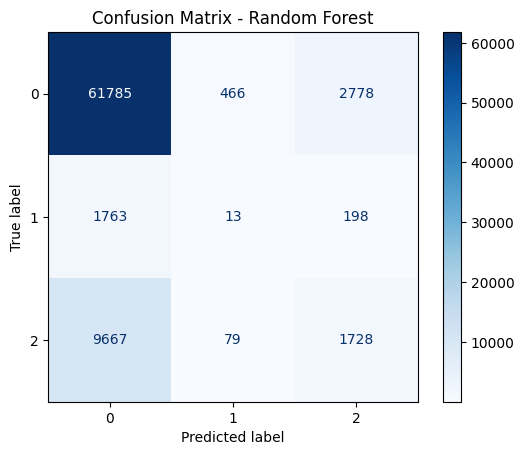

2453/2453 ━━━━━━━━━━━━━━━━━━━━ 2s 832us/step

Classification Report for Neural Network:
              precision    recall  f1-score   support

         0.0       0.92      0.74      0.82     65029
         1.0       0.00      0.00      0.00      1974
         2.0       0.32      0.72      0.44     11474

    accuracy                           0.72     78477
   macro avg       0.41      0.49      0.42     78477
weighted avg       0.81      0.72      0.75     78477

ROC-AUC Score for Neural Network: 0.7925


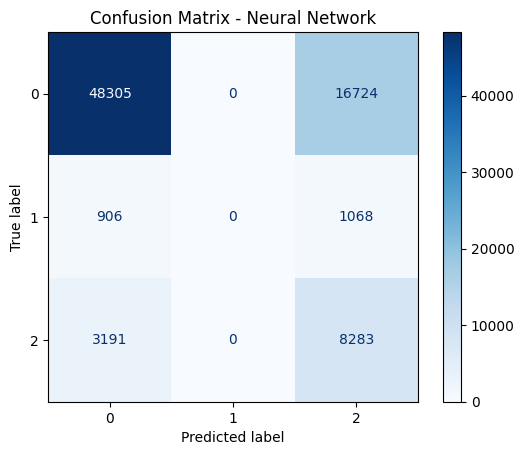

In [7]:
# Verify GPU availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("GPU:", tf.config.list_physical_devices('GPU')[0].name)
else:
    print("No GPU detected. Training will use CPU.")

# Define paths
processed_data_path = '../data/processed/'
models_path = '../models/'

# Create models directory if it doesn't exist
os.makedirs(models_path, exist_ok=True)

# Load preprocessed data
X_train = np.load(os.path.join(processed_data_path, 'X_train.npy'))
X_test = np.load(os.path.join(processed_data_path, 'X_test.npy'))
y_train = np.load(os.path.join(processed_data_path, 'y_train.npy'))
y_test = np.load(os.path.join(processed_data_path, 'y_test.npy'))

# Check shapes
print("Shapes - X_train:", X_train.shape, "X_test:", X_test.shape)
print("Shapes - y_train:", y_train.shape, "y_test:", y_test.shape)

# Apply SMOTE with adjusted sampling strategy
smote = SMOTE(sampling_strategy={1: 5000, 2: 26772}, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
X_train_res = X_train_res.toarray() if hasattr(X_train_res, 'toarray') else X_train_res
y_train_res = y_train_res.astype(np.float32)
print("Shapes after SMOTE - X_train_res:", X_train_res.shape, "y_train_res:", y_train_res.shape)

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_res, y_train_res)
dump(log_reg, os.path.join(models_path, 'logistic_regression_smote.pkl'))

# Train Random Forest with tuned parameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, class_weight='balanced')
rf_model.fit(X_train_res, y_train_res)
dump(rf_model, os.path.join(models_path, 'random_forest_smote_tuned.pkl'))

# Prepare data for Neural Network
y_train_cat = to_categorical(y_train_res, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Build and train Neural Network with weighted loss
with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
    nn_model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_res.shape[1],)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    class_weights = {0: 1.0, 1: 10.0, 2: 5.0}  # Higher weights for minority classes
    history = nn_model.fit(X_train_res, y_train_cat, epochs=30, batch_size=128, validation_split=0.2,
                          verbose=1, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                          class_weight=class_weights)
    nn_model.save(os.path.join(models_path, 'neural_net_tuned.h5'))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate all models
models = {'Logistic Regression': log_reg, 'Random Forest': rf_model}
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score for {name}: {roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr'):.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Evaluate Neural Network
y_pred_nn = nn_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)
print("\nClassification Report for Neural Network:")
print(classification_report(y_test, y_pred_nn_classes))
print(f"ROC-AUC Score for Neural Network: {roc_auc_score(y_test, y_pred_nn, multi_class='ovr', average='weighted'):.4f}")

cm_nn = confusion_matrix(y_test, y_pred_nn_classes)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn)
disp_nn.plot(cmap='Blues')
plt.title('Confusion Matrix - Neural Network')
plt.show()

Num GPUs Available: 0
No GPU detected. Training will use CPU.
Shapes - X_train: (183112, 48) X_test: (78477, 48)
Shapes - y_train: (183112,) y_test: (78477,)
Shapes after SMOTE - X_train_res: (188505, 48) y_train_res: (188505,)
Epoch 1/30
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6918 - loss: 1.8193 - val_accuracy: 0.5744 - val_loss: 0.8790
Epoch 2/30
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6980 - loss: 1.7872 - val_accuracy: 0.6045 - val_loss: 0.8368
Epoch 3/30
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6981 - loss: 1.7756 - val_accuracy: 0.6140 - val_loss: 0.8228
Epoch 4/30
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6971 - loss: 1.7736 - val_accuracy: 0.5792 - val_loss: 0.8568
Epoch 5/30
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6965 - loss: 1.7665 - val_accuracy: 0.6022 - val_loss: 0.8478
Epoch 6/30
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6979 - loss: 1.7607 - val_accuracy: 0.5814 - val_loss:

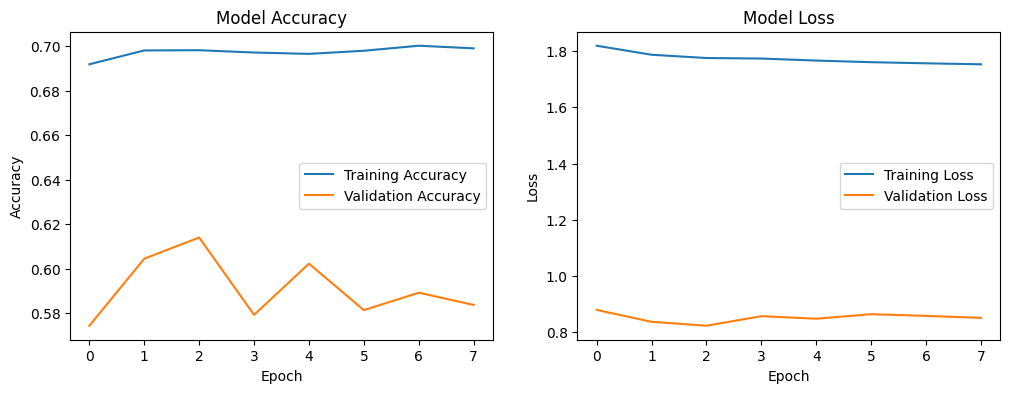


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.94      0.63      0.75     65029
         1.0       0.04      0.30      0.07      1974
         2.0       0.33      0.57      0.42     11474

    accuracy                           0.61     78477
   macro avg       0.44      0.50      0.41     78477
weighted avg       0.83      0.61      0.69     78477

ROC-AUC Score for Logistic Regression: 0.7435


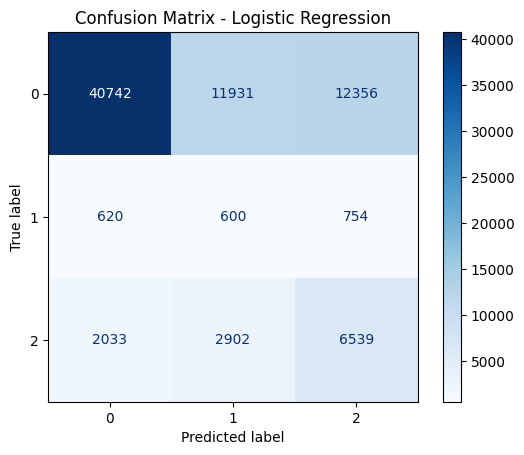


Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89     65029
         1.0       0.03      0.01      0.01      1974
         2.0       0.36      0.15      0.21     11474

    accuracy                           0.81     78477
   macro avg       0.41      0.37      0.37     78477
weighted avg       0.75      0.81      0.77     78477

ROC-AUC Score for Random Forest: 0.7049


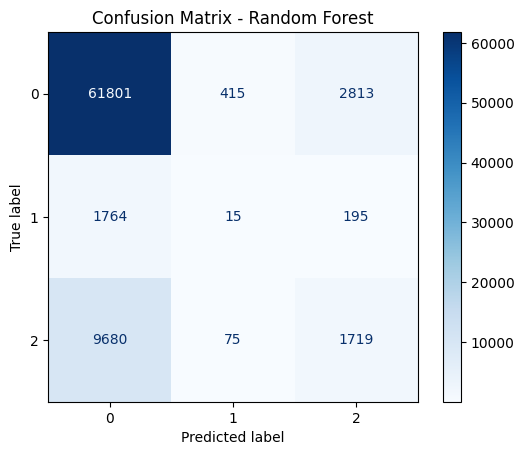

2453/2453 ━━━━━━━━━━━━━━━━━━━━ 2s 792us/step

Classification Report for Neural Network:
              precision    recall  f1-score   support

         0.0       0.92      0.75      0.83     65029
         1.0       0.11      0.00      0.00      1974
         2.0       0.32      0.71      0.44     11474

    accuracy                           0.72     78477
   macro avg       0.45      0.49      0.42     78477
weighted avg       0.81      0.72      0.75     78477

ROC-AUC Score for Neural Network: 0.7907


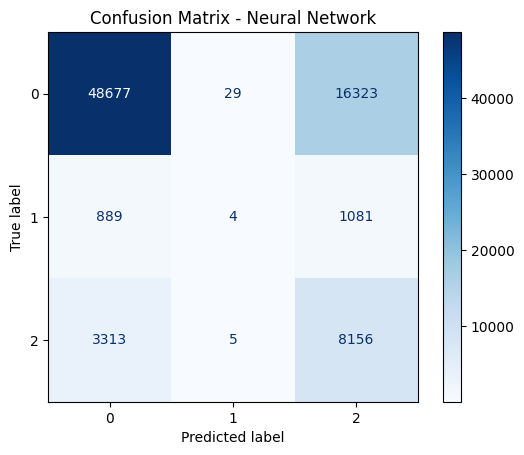

In [8]:
# Verify GPU availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("GPU:", tf.config.list_physical_devices('GPU')[0].name)
else:
    print("No GPU detected. Training will use CPU.")

# Define paths
processed_data_path = '../data/processed/'
models_path = '../models/'

# Create models directory if it doesn't exist
os.makedirs(models_path, exist_ok=True)

# Load preprocessed data
X_train = np.load(os.path.join(processed_data_path, 'X_train.npy'))
X_test = np.load(os.path.join(processed_data_path, 'X_test.npy'))
y_train = np.load(os.path.join(processed_data_path, 'y_train.npy'))
y_test = np.load(os.path.join(processed_data_path, 'y_test.npy'))

# Check shapes
print("Shapes - X_train:", X_train.shape, "X_test:", X_test.shape)
print("Shapes - y_train:", y_train.shape, "y_test:", y_test.shape)

# Apply SMOTE with adjusted sampling strategy
smote = SMOTE(sampling_strategy={1: 10000, 2: 26772}, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
X_train_res = X_train_res.toarray() if hasattr(X_train_res, 'toarray') else X_train_res
y_train_res = y_train_res.astype(np.float32)
print("Shapes after SMOTE - X_train_res:", X_train_res.shape, "y_train_res:", y_train_res.shape)

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_res, y_train_res)
dump(log_reg, os.path.join(models_path, 'logistic_regression_smote.pkl'))

# Train Random Forest with tuned parameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, class_weight='balanced')
rf_model.fit(X_train_res, y_train_res)
dump(rf_model, os.path.join(models_path, 'random_forest_smote_tuned.pkl'))

# Prepare data for Neural Network
y_train_cat = to_categorical(y_train_res, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Build and train Neural Network with weighted loss
with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
    nn_model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_res.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    class_weights = {0: 1.0, 1: 15.0, 2: 5.0}
    history = nn_model.fit(X_train_res, y_train_cat, epochs=30, batch_size=128, validation_split=0.2,
                          verbose=1, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                          class_weight=class_weights)
    nn_model.save(os.path.join(models_path, 'neural_net_tuned.h5'))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate all models
models = {'Logistic Regression': log_reg, 'Random Forest': rf_model}
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score for {name}: {roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr'):.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Evaluate Neural Network
y_pred_nn = nn_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)
print("\nClassification Report for Neural Network:")
print(classification_report(y_test, y_pred_nn_classes))
print(f"ROC-AUC Score for Neural Network: {roc_auc_score(y_test, y_pred_nn, multi_class='ovr', average='weighted'):.4f}")

cm_nn = confusion_matrix(y_test, y_pred_nn_classes)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn)
disp_nn.plot(cmap='Blues')
plt.title('Confusion Matrix - Neural Network')
plt.show()

Num GPUs Available: 0
No GPU detected. Training will use CPU.
Original class distribution: [151733   4607  26772]
Shapes - X_train: (183112, 48) X_test: (78477, 48)
Shapes - y_train: (183112,) y_test: (78477,)
Shapes after SMOTE - X_train_res: (196733, 48) y_train_res: (196733,)
Resampled class distribution: [151733  15000  30000]
Epoch 1/50
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5422 - loss: 2.7574 - val_accuracy: 0.4720 - val_loss: 1.0199
Epoch 2/50
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5680 - loss: 2.7046 - val_accuracy: 0.4445 - val_loss: 1.0982
Epoch 3/50
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5719 - loss: 2.6908 - val_accuracy: 0.4388 - val_loss: 1.0553
Epoch 4/50
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5732 - loss: 2.6815 - val_accuracy: 0.4504 - val_loss: 1.0812
Epoch 5/50
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5717 - loss: 2.6805 - val_accuracy: 0.4248 - val_loss: 1.0784
Epoch 6/50
2460/2

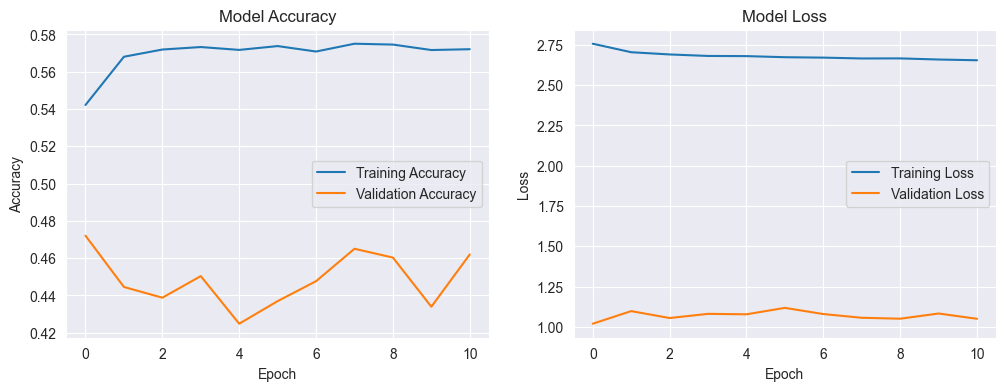


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.94      0.63      0.75     65029
         1.0       0.04      0.31      0.07      1974
         2.0       0.33      0.56      0.42     11474

    accuracy                           0.61     78477
   macro avg       0.44      0.50      0.41     78477
weighted avg       0.83      0.61      0.68     78477

ROC-AUC Score for Logistic Regression: 0.7423


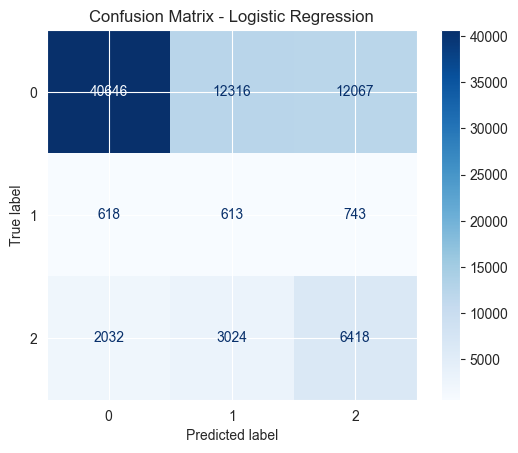


Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89     65029
         1.0       0.03      0.01      0.01      1974
         2.0       0.37      0.16      0.22     11474

    accuracy                           0.81     78477
   macro avg       0.41      0.37      0.38     78477
weighted avg       0.75      0.81      0.77     78477

ROC-AUC Score for Random Forest: 0.7039


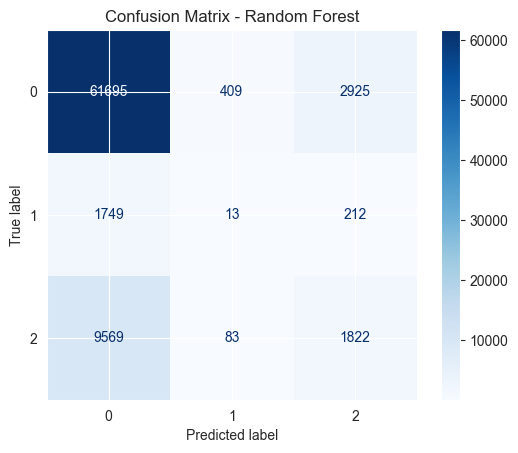

2453/2453 ━━━━━━━━━━━━━━━━━━━━ 1s 580us/step

Classification Report for Neural Network:
              precision    recall  f1-score   support

         0.0       0.94      0.60      0.73     65029
         1.0       0.00      0.00      0.00      1974
         2.0       0.26      0.85      0.40     11474

    accuracy                           0.62     78477
   macro avg       0.40      0.48      0.38     78477
weighted avg       0.82      0.62      0.66     78477

ROC-AUC Score for Neural Network: 0.7883


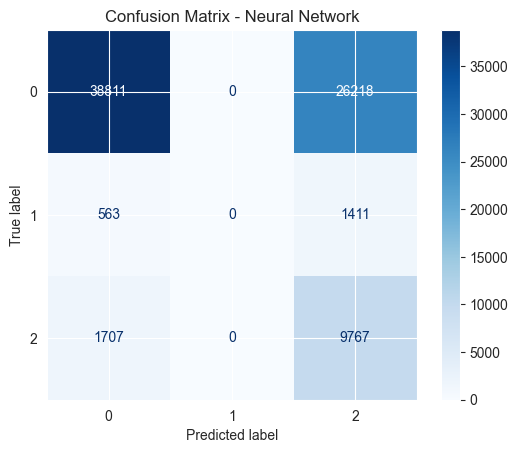

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from joblib import load, dump
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Verify GPU availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("GPU:", tf.config.list_physical_devices('GPU')[0].name)
else:
    print("No GPU detected. Training will use CPU.")

# Define paths
processed_data_path = '../data/processed/'
models_path = '../models/'

# Create models directory if it doesn't exist
os.makedirs(models_path, exist_ok=True)

# Load preprocessed data
X_train = np.load(os.path.join(processed_data_path, 'X_train.npy'))
X_test = np.load(os.path.join(processed_data_path, 'X_test.npy'))
y_train = np.load(os.path.join(processed_data_path, 'y_train.npy'))
y_test = np.load(os.path.join(processed_data_path, 'y_test.npy'))

# Check original class distribution
print("Original class distribution:", np.bincount(y_train.astype(int)))

# Check shapes
print("Shapes - X_train:", X_train.shape, "X_test:", X_test.shape)
print("Shapes - y_train:", y_train.shape, "y_test:", y_test.shape)

# Apply SMOTE with adjusted sampling strategy (increase class 1 further)
smote = SMOTE(sampling_strategy={1: 15000, 2: 30000}, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
X_train_res = X_train_res.toarray() if hasattr(X_train_res, 'toarray') else X_train_res
y_train_res = y_train_res.astype(np.float32)
print("Shapes after SMOTE - X_train_res:", X_train_res.shape, "y_train_res:", y_train_res.shape)
print("Resampled class distribution:", np.bincount(y_train_res.astype(int)))

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_res, y_train_res)
dump(log_reg, os.path.join(models_path, 'logistic_regression_smote.pkl'))

# Train Random Forest with tuned parameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, class_weight='balanced')
rf_model.fit(X_train_res, y_train_res)
dump(rf_model, os.path.join(models_path, 'random_forest_smote_tuned.pkl'))

# Prepare data for Neural Network
y_train_cat = to_categorical(y_train_res, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Build and train Neural Network with improved architecture and weights
with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
    nn_model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train_res.shape[1],)),  # Increased units
        Dropout(0.4),  # Increased dropout
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    class_weights = {0: 1.0, 1: 25.0, 2: 10.0}  # Increased weights for minority classes
    history = nn_model.fit(X_train_res, y_train_cat, epochs=50, batch_size=64, validation_split=0.2,
                          verbose=1, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
                          class_weight=class_weights)
    nn_model.save(os.path.join(models_path, 'neural_net_tuned.h5'))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate all models
models = {'Logistic Regression': log_reg, 'Random Forest': rf_model}
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score for {name}: {roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr'):.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Evaluate Neural Network
y_pred_nn = nn_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)
print("\nClassification Report for Neural Network:")
print(classification_report(y_test, y_pred_nn_classes))
print(f"ROC-AUC Score for Neural Network: {roc_auc_score(y_test, y_pred_nn, multi_class='ovr', average='weighted'):.4f}")

cm_nn = confusion_matrix(y_test, y_pred_nn_classes)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn)
disp_nn.plot(cmap='Blues')
plt.title('Confusion Matrix - Neural Network')
plt.show()

Num GPUs Available: 0
No GPU detected. Training will use CPU.
Original class distribution: [151733   4607  26772]
Shapes - X_train: (183112, 48) X_test: (78477, 48)
Shapes - y_train: (183112,) y_test: (78477,)
Shapes after SMOTE - X_train_res: (196733, 48) y_train_res: (196733,)
Resampled class distribution: [151733  15000  30000]
Best XGBoost parameters: {'subsample': 0.6, 'scale_pos_weight': 1, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Epoch 1/50
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5370 - loss: 2.7567 - val_accuracy: 0.4527 - val_loss: 1.0451
Epoch 2/50
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5685 - loss: 2.7047 - val_accuracy: 0.4572 - val_loss: 1.0623
Epoch 3/50
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5724 - loss: 2.6920 - val_accuracy: 0.4549 - val_loss: 1.0539
Epoch 4/50
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5705 - loss: 2.6861 - val_accuracy: 0.4593 - val_loss: 1.0

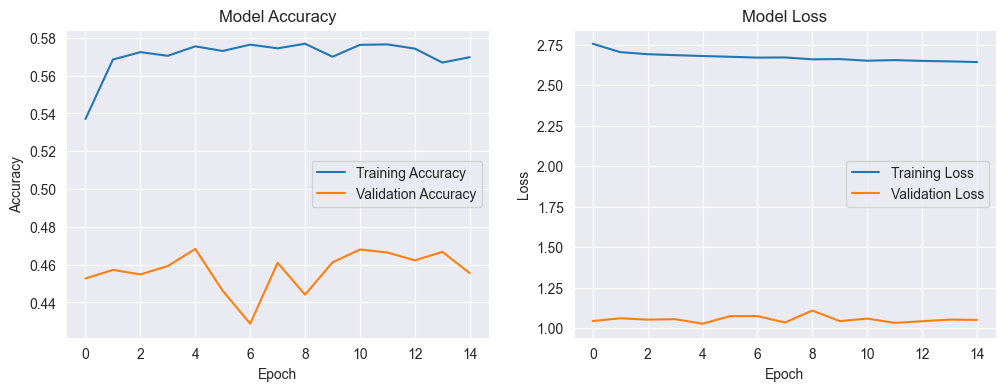


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.94      0.63      0.75     65029
         1.0       0.04      0.31      0.07      1974
         2.0       0.33      0.56      0.42     11474

    accuracy                           0.61     78477
   macro avg       0.44      0.50      0.41     78477
weighted avg       0.83      0.61      0.68     78477

ROC-AUC Score for Logistic Regression: 0.7423


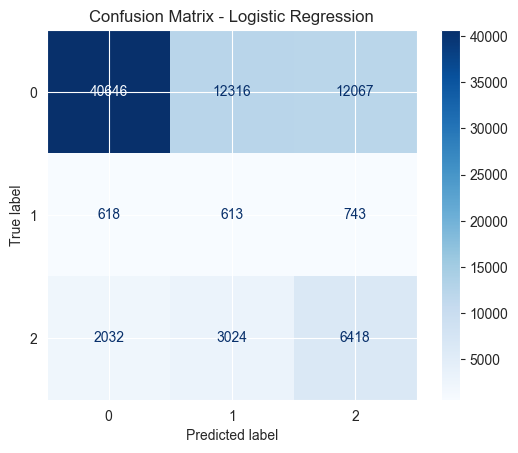


Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89     65029
         1.0       0.03      0.01      0.01      1974
         2.0       0.37      0.16      0.22     11474

    accuracy                           0.81     78477
   macro avg       0.41      0.37      0.38     78477
weighted avg       0.75      0.81      0.77     78477

ROC-AUC Score for Random Forest: 0.7039


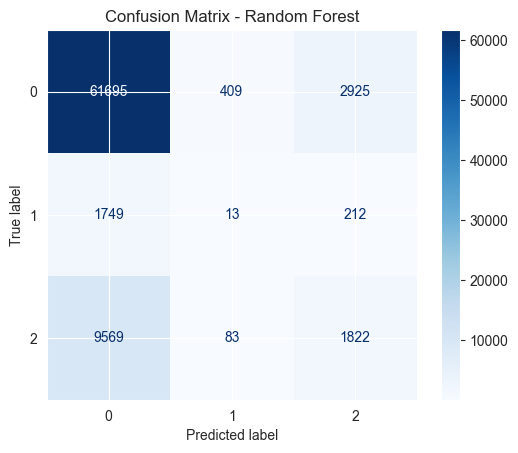


Classification Report for XGBoost:
              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91     65029
         1.0       0.00      0.00      0.00      1974
         2.0       0.50      0.15      0.24     11474

    accuracy                           0.83     78477
   macro avg       0.45      0.38      0.38     78477
weighted avg       0.78      0.83      0.79     78477

ROC-AUC Score for XGBoost: 0.7408


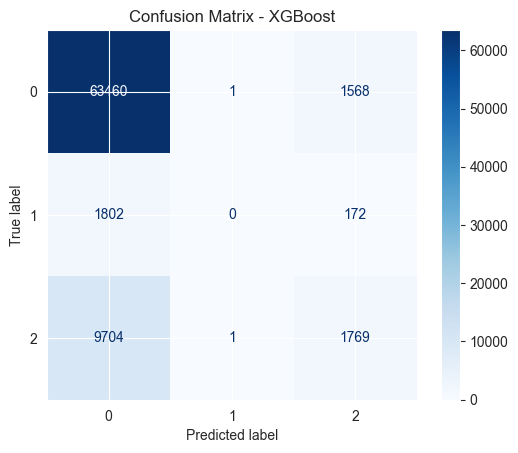

2453/2453 ━━━━━━━━━━━━━━━━━━━━ 2s 577us/step

Classification Report for Neural Network:
              precision    recall  f1-score   support

         0.0       0.95      0.58      0.72     65029
         1.0       0.08      0.00      0.00      1974
         2.0       0.26      0.86      0.40     11474

    accuracy                           0.61     78477
   macro avg       0.43      0.48      0.37     78477
weighted avg       0.83      0.61      0.66     78477

ROC-AUC Score for Neural Network: 0.7909


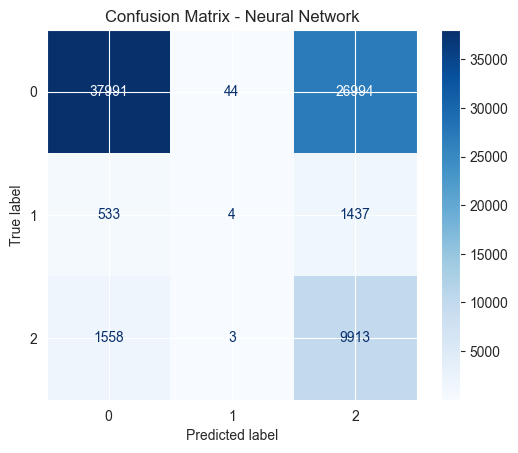

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# Verify GPU availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("GPU:", tf.config.list_physical_devices('GPU')[0].name)
else:
    print("No GPU detected. Training will use CPU.")

# Define paths
processed_data_path = '../data/processed/'
models_path = '../models/'

# Create models directory if it doesn't exist
os.makedirs(models_path, exist_ok=True)

# Load preprocessed data
X_train = np.load(os.path.join(processed_data_path, 'X_train.npy'))
X_test = np.load(os.path.join(processed_data_path, 'X_test.npy'))
y_train = np.load(os.path.join(processed_data_path, 'y_train.npy'))
y_test = np.load(os.path.join(processed_data_path, 'y_test.npy'))

# Check original class distribution
print("Original class distribution:", np.bincount(y_train.astype(int)))

# Check shapes
print("Shapes - X_train:", X_train.shape, "X_test:", X_test.shape)
print("Shapes - y_train:", y_train.shape, "y_test:", y_test.shape)

# Apply SMOTE with adjusted sampling strategy
smote = SMOTE(sampling_strategy={1: 15000, 2: 30000}, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
X_train_res = X_train_res.toarray() if hasattr(X_train_res, 'toarray') else X_train_res
y_train_res = y_train_res.astype(np.float32)
print("Shapes after SMOTE - X_train_res:", X_train_res.shape, "y_train_res:", y_train_res.shape)
print("Resampled class distribution:", np.bincount(y_train_res.astype(int)))

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_res, y_train_res)
dump(log_reg, os.path.join(models_path, 'logistic_regression_smote.pkl'))

# Train Random Forest with tuned parameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, class_weight='balanced')
rf_model.fit(X_train_res, y_train_res)
dump(rf_model, os.path.join(models_path, 'random_forest_smote_tuned.pkl'))

# Train XGBoost with hyperparameter tuning
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [1, 5, 10],  # Adjust for class imbalance
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
random_search = RandomizedSearchCV(xgb_model, param_grid, n_iter=10, cv=3, scoring='f1_weighted', random_state=42, n_jobs=-1)
random_search.fit(X_train_res, y_train_res)
xgb_best = random_search.best_estimator_
dump(xgb_best, os.path.join(models_path, 'xgboost_tuned.pkl'))
print("Best XGBoost parameters:", random_search.best_params_)

# Prepare data for Neural Network
y_train_cat = to_categorical(y_train_res, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Build and train Neural Network with improved architecture
with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
    nn_model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train_res.shape[1],)),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    class_weights = {0: 1.0, 1: 25.0, 2: 10.0}
    history = nn_model.fit(X_train_res, y_train_cat, epochs=50, batch_size=64, validation_split=0.2,
                          verbose=1, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
                          class_weight=class_weights)
    nn_model.save(os.path.join(models_path, 'neural_net_tuned.h5'))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate all models
models = {'Logistic Regression': log_reg, 'Random Forest': rf_model, 'XGBoost': xgb_best}
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score for {name}: {roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr'):.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Evaluate Neural Network
y_pred_nn = nn_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)
print("\nClassification Report for Neural Network:")
print(classification_report(y_test, y_pred_nn_classes))
print(f"ROC-AUC Score for Neural Network: {roc_auc_score(y_test, y_pred_nn, multi_class='ovr', average='weighted'):.4f}")

cm_nn = confusion_matrix(y_test, y_pred_nn_classes)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn)
disp_nn.plot(cmap='Blues')
plt.title('Confusion Matrix - Neural Network')
plt.show()

Num GPUs Available: 0
No GPU detected. Training will use CPU.
Best XGBoost parameters: {'subsample': 0.8, 'scale_pos_weight': 2, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Epoch 1/50
670/670 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7116 - loss: 0.6153 - val_accuracy: 0.6950 - val_loss: 0.5597
Epoch 2/50
670/670 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7278 - loss: 0.5952 - val_accuracy: 0.7064 - val_loss: 0.5534
Epoch 3/50
670/670 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7306 - loss: 0.5914 - val_accuracy: 0.7008 - val_loss: 0.5478
Epoch 4/50
670/670 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7328 - loss: 0.5861 - val_accuracy: 0.6957 - val_loss: 0.5727
Epoch 5/50
670/670 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7348 - loss: 0.5854 - val_accuracy: 0.6991 - val_loss: 0.5659
Epoch 6/50
670/670 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7350 - loss: 0.5844 - val_accuracy: 0.7045 - val_loss: 0.5516
Epoch 7/50
670/670 

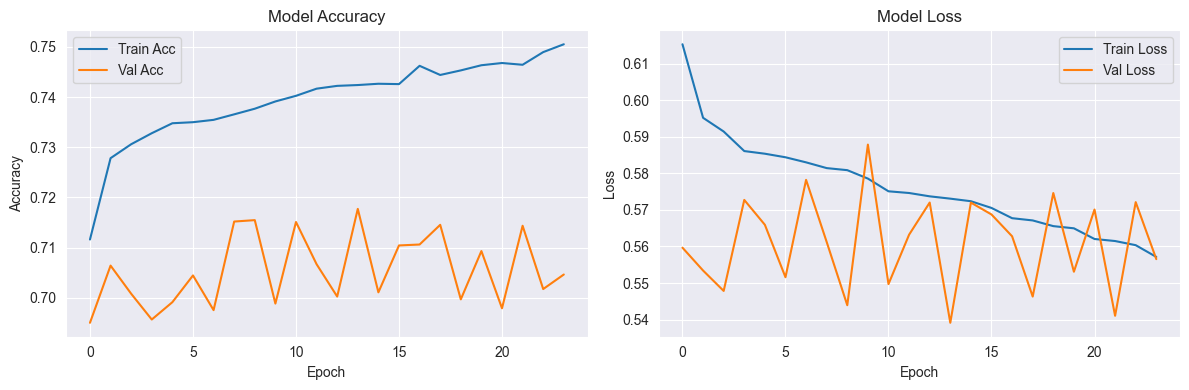


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.72      0.71      0.71     10071
         1.0       0.75      0.75      0.75     11474

    accuracy                           0.73     21545
   macro avg       0.73      0.73      0.73     21545
weighted avg       0.73      0.73      0.73     21545

ROC-AUC Score for Logistic Regression: 0.8074


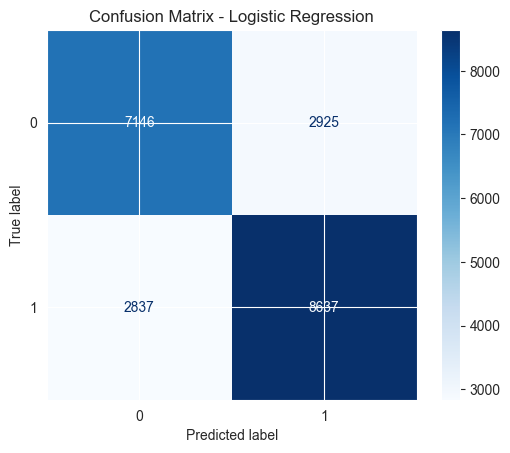


Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.72      0.65      0.68     10071
         1.0       0.71      0.77      0.74     11474

    accuracy                           0.72     21545
   macro avg       0.72      0.71      0.71     21545
weighted avg       0.72      0.72      0.71     21545

ROC-AUC Score for Random Forest: 0.7804


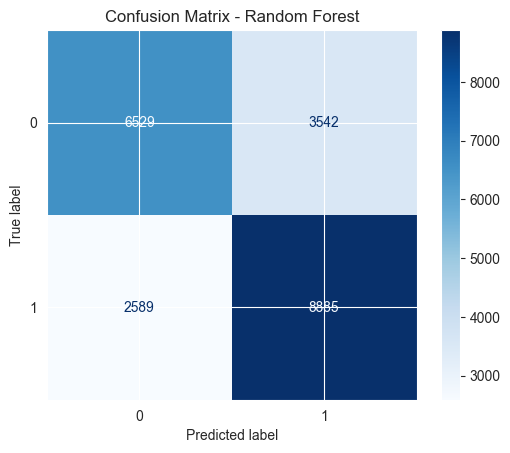


Classification Report for XGBoost:
              precision    recall  f1-score   support

         0.0       0.82      0.51      0.63     10071
         1.0       0.68      0.91      0.77     11474

    accuracy                           0.72     21545
   macro avg       0.75      0.71      0.70     21545
weighted avg       0.75      0.72      0.71     21545

ROC-AUC Score for XGBoost: 0.8049


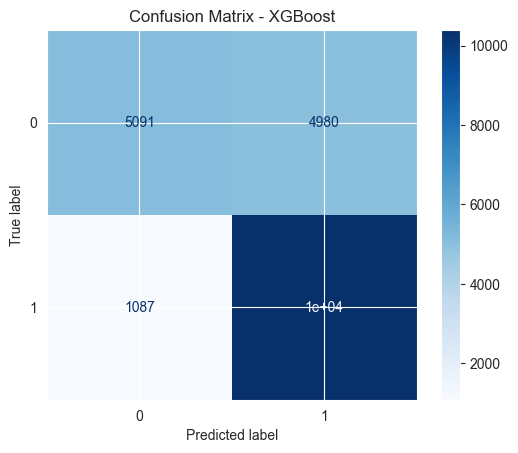

674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step

Classification Report for Neural Network:
              precision    recall  f1-score   support

         0.0       0.75      0.66      0.70     10071
         1.0       0.73      0.81      0.76     11474

    accuracy                           0.74     21545
   macro avg       0.74      0.73      0.73     21545
weighted avg       0.74      0.74      0.73     21545

ROC-AUC Score for Neural Network: 0.8060


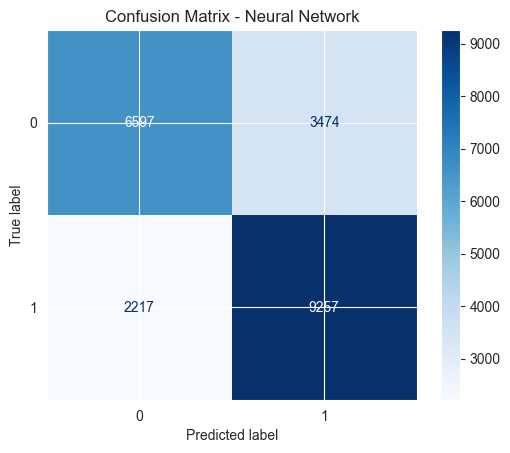

In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from joblib import dump
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')

# Verify GPU availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("GPU:", tf.config.list_physical_devices('GPU')[0].name)
else:
    print("No GPU detected. Training will use CPU.")

# ----------------- Paths -----------------
processed_data_path = '../data/processed/'
models_path = '../models/'
os.makedirs(models_path, exist_ok=True)

# ----------------- Load Data -----------------
X_train_balanced = np.load(os.path.join(processed_data_path, 'X_train_balanced.npy'))
X_test_balanced = np.load(os.path.join(processed_data_path, 'X_test_balanced.npy'))
y_train_balanced = np.load(os.path.join(processed_data_path, 'y_train_balanced.npy'))
y_test_balanced = np.load(os.path.join(processed_data_path, 'y_test_balanced.npy'))

# ----------------- SMOTE (Optional) -----------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_balanced, y_train_balanced)
y_train_res = y_train_res.astype(np.float32)

# ----------------- Logistic Regression -----------------
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_res, y_train_res)
dump(log_reg, os.path.join(models_path, 'logistic_regression_balanced.pkl'))

# ----------------- Random Forest -----------------
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, class_weight='balanced')
rf_model.fit(X_train_res, y_train_res)
dump(rf_model, os.path.join(models_path, 'random_forest_balanced_tuned.pkl'))

# ----------------- XGBoost with RandomizedSearchCV -----------------
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [1, 2, 3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    xgb_model, param_grid, n_iter=10, cv=3, scoring='f1', random_state=42, n_jobs=-1
)
random_search.fit(X_train_res, y_train_res)
xgb_best = random_search.best_estimator_
dump(xgb_best, os.path.join(models_path, 'xgboost_balanced_tuned.pkl'))
print("Best XGBoost parameters:", random_search.best_params_)

# ----------------- Neural Network -----------------
y_train_cat = to_categorical(y_train_res, num_classes=2)

with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
    nn_model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train_res.shape[1],)),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(2, activation='softmax')  # Binary classification
    ])
    nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    class_weights = {0: 1.0, 1: 1.2}
    history = nn_model.fit(
        X_train_res, y_train_cat,
        epochs=50,
        batch_size=64,
        validation_split=0.2,
        verbose=1,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        class_weight=class_weights
    )
    nn_model.save(os.path.join(models_path, 'neural_net_balanced_tuned.h5'))

# ----------------- Plot Training History -----------------
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------- Evaluate scikit-learn Models -----------------
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf_model,
    'XGBoost': xgb_best
}

for name, model in models.items():
    y_pred = model.predict(X_test_balanced)
    y_proba = model.predict_proba(X_test_balanced)[:, 1]

    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test_balanced, y_pred))
    print(f"ROC-AUC Score for {name}: {roc_auc_score(y_test_balanced, y_proba):.4f}")

    cm = confusion_matrix(y_test_balanced, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# ----------------- Evaluate Neural Network -----------------
y_pred_nn = nn_model.predict(X_test_balanced)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

print("\nClassification Report for Neural Network:")
print(classification_report(y_test_balanced, y_pred_nn_classes))
print(f"ROC-AUC Score for Neural Network: {roc_auc_score(y_test_balanced, y_pred_nn[:, 1]):.4f}")

cm_nn = confusion_matrix(y_test_balanced, y_pred_nn_classes)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn)
disp_nn.plot(cmap='Blues')
plt.title('Confusion Matrix - Neural Network')
plt.show()
